In [9]:
import sys
sys.path.append('../')

from raypy.utils.vector3 import vec3
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from functools import reduce as reduce

# Ray Tracer

## Einleitung

Auf Deutsch bezeichnet der englische Begriff „Ray tracing“ das „Nachverfolgen von Strahlen“. Genauer gesagt: Lichtstrahlen. Als Grafik-Technologie ermöglicht Ray tracing die Simulierung von Lichteffekten. Ein Algorithmus sendet hierzu Strahlen in einer 3D-Grafik aus, verfolgt die Strahlenpfade und berechnet ein realistisches Beleuchtungsmodell.

In der realen Welt senden Lichtquellen Lichtstrahlen aus, die dann auf Objekte treffen, dort gebrochen, reflektiert oder gestreut werden und schlussendlich bei der Kamera ankommen.
Die von der Kamera erfassten Lichtstrahlen sind deshalb nur ein Bruchteil der Lichtstrahlen, die von der Lichtquelle zwar ausgesendet, von der Kamera aber nicht aufgenommen werden.

Um nur die, für die Kamera wichtigen, Lichtstrahlen zu berechnen, wird der Weg des Lichts beim Ray tracing entgegen der natürlichen Richtung berechnet.
Die Lichtstrahlen werden also von der Kamera ausgesendet und zurückverfolgt. Die folgende Grafik zeigt wie ein Ray aus der Kamera durch die Bildebene in den drei dimensionalen Raum gesendet wird.

<img src="assets/rayTracingOverview.png" width=500px></img>

Beim Ray tracing werden ausgehend vom Augpunkt für jeden Pixel der Bildebene wird ein Ray ausgesendet. Die Rays durchstoßen die Bildebene und treffen dann auf die Objekte im drei dimensionalen Raum.
Die Farbe eines jeden Pixels der Bildebene wird durch die sog. Rendergleichung berechnet.

## Was ist ein Ray

Ein Ray, oder auch ein Lichtstrahl, ist die Kombination aus einem Ursprung und einer Richtung.
Ursprung und Richtung eines Rays können jeweils durch einen Vektor angegeben werden. Durch die Linearkombination 
des Ortsvektors (Ursprung) und des Richtungsvektors kann so jeder beliebige Punkt auf einem Ray angegeben werden.

<img src="assets/ray.jpg" width=500px></img>

Die Gleichung für eine Ray ist also folgenden: $\vec{Ray(t)}=\vec{A}+\vec{B}*t$

Die einfachste Implementierung eins Rays wäre also folgende:

In [10]:
class Ray:
  """Info of the ray and the media it's travelling"""

  def __init__(self, origin, dir):
      self.origin = origin  # the point where the ray comes from
      self.dir = dir  # direction of the ray

## Die Kamera

Die Kamera befindet sich am Augpunkt und schaut in eine definierte Richtung. Die Anzahl der ausgesendeten Rays hängt von der Anzahl der Pixel ab. 

In [13]:
class Camera():
    def __init__(self, look_from, look_at, screen_width=400, screen_height=400, field_of_view=90.):
        self.screen_width = screen_width
        self.screen_height = screen_height
        self.aspect_ratio = float(screen_width) / screen_height
        self.look_from = look_from
        self.look_at = look_at
        self.camera_width = np.tan(field_of_view * np.pi / 180 / 2.) * 2.
        self.camera_height = self.camera_width / self.aspect_ratio

        # camera reference basis in world coordinates
        self.cameraFwd = (look_at - look_from).normalize()
        self.cameraRight = (self.cameraFwd.cross(vec3(0., 1., 0.))).normalize()
        self.cameraUp = self.cameraRight.cross(self.cameraFwd)

        # Pixels coordinates in camera basis:
        self.x = np.linspace(-self.camera_width / 2., self.camera_width / 2., self.screen_width)
        self.y = np.linspace(self.camera_height / 2., -self.camera_height / 2., self.screen_height)

        # x holds all x values
        # y holds all y values
        # meshgrid creates a rectangular grid with all combinations of (x,y)
        # xx and yy hold the x and y values of the rectangular grid: https://stackoverflow.com/a/42404323
        xx, yy = np.meshgrid(self.x, self.y)
        self.x = xx.flatten()
        self.y = yy.flatten()

    def get_ray(self):

        # in each pixel, take a random position to avoid aliasing.
        x = self.x + (np.random.rand(len(self.x)) - 0.5) * self.camera_width / self.screen_width
        y = self.y + (np.random.rand(len(self.y)) - 0.5) * self.camera_height / self.screen_height

        # set ray direction in world space:
        # ray_origin = self.look_from + self.cameraRight * self.lens_radius + self.cameraUp * self.lens_radius
        ray_origin = self.look_from
        ray_dir = (self.look_from + self.cameraUp * y + self.cameraRight * x + self.cameraFwd - ray_origin).normalize()
        return Ray(origin=ray_origin, dir=ray_dir)


In [14]:
camera = Camera(screen_width=300 ,screen_height=300, look_from = vec3(0, 0, 10), look_at = vec3(0,0,0), field_of_view= 90)
rays = camera.get_ray()
color = rays.dir.to_array()
print(color.shape)

(3, 90000)


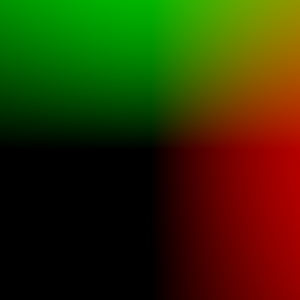

In [15]:
img_RGB = []
for channel in color:
    img_RGB += [Image.fromarray((255 * np.clip(channel, 0, 1).reshape((camera.screen_width, camera.screen_height))).astype(np.uint8), "L")]

img = Image.merge("RGB", img_RGB)
display(img)